# Problem Sheet 2

In [1]:
import numpy as np
from scipy.sparse.linalg import svds

# pywt for wavelet transform implementation
import pywt
import pywt.data

# Wrapper function around pywt transform (to get vector as an output)
from func.transforms2d import transform_wavelet2

# matplotlib for plotiing
import matplotlib.pyplot as plt
%matplotlib inline

# Sparse representation

Techninques for finding and using sparse representations are widely used in image processing (e.g. [lossy image](https://en.wikipedia.org/wiki/JPEG_2000) and [lossy video](https://www.elemental.com/applications/understanding-hevc-codec-high-efficiency-video-coding) compression)

A simple demonstration of how the cameraman image $y\in R^{512^2}$ can be compressed using Daubechies 4 wavelet transform:

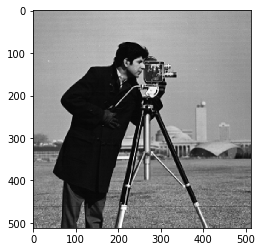

In [2]:
y = pywt.data.camera()
y = y / np.linalg.norm(y, 'fro')
plt.imshow(y, cmap ='gray')
plt.show()

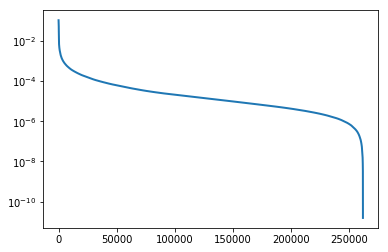

In [3]:
Psi = transform_wavelet2('Db4', mode = 'per', level = 5)
x = Psi.forward(y)
plt.semilogy(np.sort(np.abs(x))[::-1], linewidth=2)
plt.show()

Construct $\Psi$ to be a wavelet transform (Daubechies 4 order). Apply $x = \Psi y$. Now $x\in R^{512^2}$ is a vector of wavelet coefficients.

Notice in the figure above fast decay of coefficient values. This suggests that most of the information content of the image is contained only in few coefficients.

Keep only $5\%$ of the largest coefficients (in absolute value). Transform back into the image domain and observe the image.
$$
x_k = HT(x, 5\%)\\
y_k = \Psi^*(x_k)
$$

In [4]:
def thresh_hard_sparse(x, k):
    """
    Keep only k largest entries of x and return their indices.
    Parameters
    ----------
    x : numpy array
        Numpy array to be thresholded
    k : int
        Number of largest entries in absolute value to keep
    Notes
    """
    _x = x.copy()
    ind = np.argpartition(abs(_x), -k, axis=None)[-k:]
    ind = np.unravel_index(ind, _x.shape)
    ind_del = np.ones(_x.shape, dtype=bool)
    ind_del[ind] = False
    _x[ind_del] = 0
    return ind, _x

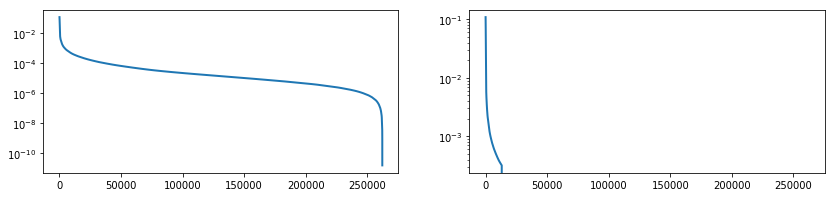

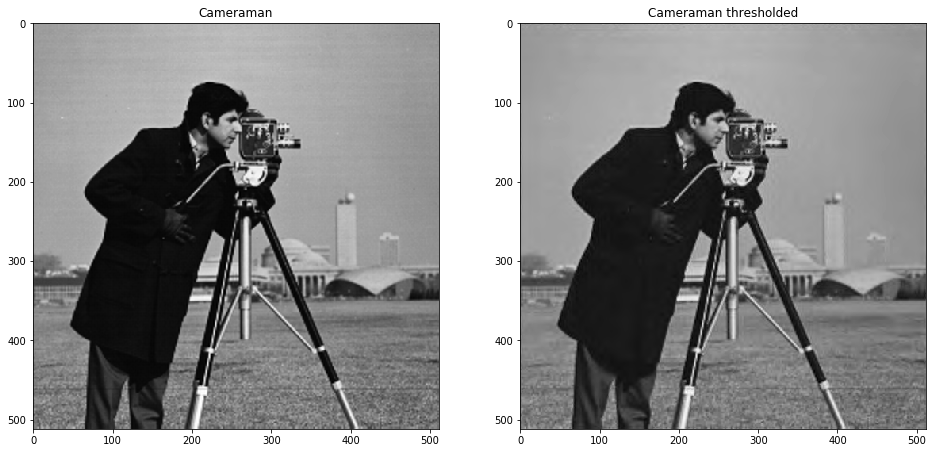

In [5]:
rho = 0.05
_, x_k = thresh_hard_sparse(x, round(rho*512**2))
y_k = Psi.backward(x_k)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14, 3))
ax1.semilogy(np.sort(np.abs(x))[::-1], linewidth=2)
ax2.semilogy(np.sort(np.abs(x_k))[::-1], linewidth=2)
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 12))
ax1.imshow(y, cmap ='gray')
ax1.set_title('Cameraman')

ax2.imshow(y_k, cmap ='gray')
ax2.set_title('Cameraman thresholded')
plt.show()

## Normalized Iterative Hard Thresholding (NIHT)
First implement NIHT [(Blumensath & Davies 2010)](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=5419091) for solving underdetermined linear system with sparse constraint:

$$
    \min_{x} \| Ax - y \|_2^2, \qquad \text{s.t.}\quad \|x\|_0\leq k, 
$$
where $A\in R^{m\times n}$, $x\in R^n$, and $y\in R^{m}$, (where $n\geq m \geq k$).

__Note__: Some of you who took C6.1 Numerical Linear Algebra last term and know of Conjugate Gradient (CG) method for solving linear systems [(Hestenes & Stiefel 1952)](https://pdfs.semanticscholar.org/466d/addfb6340c28cb8da548007028c8cc5df687.pdf), there is an equivalent method for solving linear underdetermined systems with sparsity constraints CGIHT [(Blanchard et al.2015)](https://academic.oup.com/imaiai/article/4/4/289/2357061) which has faster convergence rates.

In [6]:
def support_projection(x, ind):
    """
    Keeps only coefficients at specified indices, setting others to zero.
    ----------
    x : numpy array
        Numpy array to be projected
    ind : int
        where to keep entries keep
    """
    _x = x.copy()
    ind_del = np.ones(x.shape, dtype=bool)
    ind_del[ind] = False
    _x[ind_del] = 0
    return x

In [7]:
def niht(A, y, k, tol = 1e-4, MAX_ITER = 100):
    """
    Normalized Iterative Hard Thresholding solving underdetermined system
    Ax = b,
    Parameters
    ----------
    A : numpy array
        Underdetermined matrix
    y : numpy array
        Right-hand side vector
    k : int
        Sparsity constraint on x
    Notes
    """
    error = np.zeros(MAX_ITER)
    w = A.T.dot(y)
    T_k, x = thresh_hard_sparse(w, k)
    error[0] = np.linalg.norm(A.dot(x) - y)/np.linalg.norm(y)  
    # Iterative process
    l = 2
    not_finished = True
    while not_finished:
        r = A.T.dot(y-A.dot(x))
        r_proj = support_projection(r, T_k)
        a = np.linalg.norm(r_proj)**2
        b = np.linalg.norm(A.dot(r_proj))**2
        alpha = a/b
        w = x + alpha * r
        T_k, x = thresh_hard_sparse(w, k)
        error[l-1] = np.linalg.norm(A.dot(x) - y)/np.linalg.norm(y) 
        not_finished = (l < MAX_ITER) and (error[l-1] >= tol)
        l = l + 1
    return (x, error[:(l-1)])

### Test example of NIHT (Gaussian random matrix)
Here we test whether NIHT solver works for a generated toy problem. Consider a matrix $A\in R^{200\times 500}$ with i.i.d. entries sampled from a Gaussian distribution. Generate a random $k$-sparse $x\in R^{500}$, $\|x\|_0 = k$ and observe $y = Ax$. We run NIHT to test whether we can recover $x$ only from knowing $y$ and $A$.

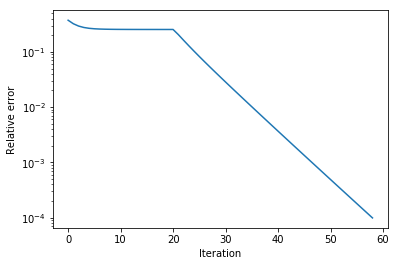

In [8]:
m = 200
n= 500
k = 10
x = np.random.randn(n, 1)
A = np.random.randn(m, n) / np.sqrt(m)
ind, x = thresh_hard_sparse(x, k)
y = np.matmul(A, x, out=None)
x, error = niht(A, y, k, tol = 1e-4, MAX_ITER = 100)
plt.plot(error)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Relative error')
plt.show()

## Implementing K-SVD
Basic implementation of K-SVD [(Aharon, Elad, Bruckstein, 2006)](https://sites.fas.harvard.edu/~cs278/papers/ksvd.pdf). Solve the following dictionary learning problem:

$$
    \min_{D,X} \| Y - DX \|_F^2, \qquad \text{s.t.} \quad \|x_i\|_0\leq T,
$$
where $Y\in R^{n\times N}$, $D\in R^{n\times K}$, $X\in R^{K\times N}$, with $N \geq n \geq K$.
- $N$ is number of samples,
- $n$ is dimension of each sample,
- $K$ is number of all dictionary elements we wish to recover,
- $T$ is how many dictionary elements are allowed to be used to approximate every sample.

In the class, we discussed Label Consistent KSVD (LC-KSVD) and Discriminative KSVD (D-KSVD): 

[Label Consistent K-SVD: Learning a Discriminative Dictionary for Recognition (Jiang et al. 2013)](https://ieeexplore.ieee.org/document/6516503) 

[On the Equivalence of the LC-KSVD and the D-KSVD Algorithms (Kviatkovsky et al. 2016)](https://ieeexplore.ieee.org/document/7439860)

There is a work on analysing convolution neural networks as a sequence of sparse dictionary learning problems.
[Convolutional Neural Networks Analyzed via Convolutional Sparse Coding (Papyan et al. 2016)](https://arxiv.org/pdf/1607.08194.pdf) 

In [9]:
def ksvd(Y,K,T, tol = 1e-4, MAX_ITER = 100, D_init = np.array([])):
    """
    Simple implementation of K-SVD, solving
    Y \approx D X,
    Parameters
    ----------
    Y : numpy array
        Matrix of data samples
    K : int
        Number of dictionary elements
    T : int
        Sparsity constraint on how many dictionary elements to be used for every sample
    Notes
    """
    error = np.zeros(MAX_ITER)
    # Get sizes of the problem
    n, N = Y.shape
    # Gaussian random initialization for D
    # D = np.random.randn(n, K) / np.sqrt(n)
    # Initialize dictionary with data
    if not D_init:
        D = Y[:,:K] / np.linalg.norm(Y[:,:K], axis=0)
    else:
        D = D_init.copy()
    X = np.zeros((K,N))
    # Iterative process
    J = 1
    not_finished = True
    while not_finished:
        # Sparse Coding Stage
        for i in range(N):
            #print(D.shape, Y[:,i].shape, Y.shape)
            x_tmp,_ = niht(D, Y[:,i], T, tol = 1e-7, MAX_ITER = 80)
            X[:,i] = x_tmp

        error[J-1] = np.linalg.norm(Y - D @ X, ord='fro')/np.linalg.norm(Y, ord='fro')
        print(error[J-1])
        # Codebook Update Stage
        for k in range(K):
            w_k = np.where(X[k,:] != 0)[0]
            if w_k.size > 1:
                ind = np.ones((K,), bool)
                ind[k] = False
                E_k = Y - D[:,ind] @ X[ind,:]
                u, s, vt = svds(E_k[:,w_k], k = 1)
                D[:,k] = u.T
                X[k,w_k] = s[0] * vt
        not_finished = (J < MAX_ITER) and (error[J-1] >= tol)
        J = J + 1
    return (D,X,error)

## Test on MNIST
*Warning*: Takes a while to run. Setting $N$ (number of images used) and $K$ (number of dictionary elements) lower makes for faster computation. Making the sparse constraint $T$ higher allows for less sparse representations, resulting in lower error (at the expense of more dense representations).

In [10]:
# Load MNIST using torchvision.datasets
from torchvision import datasets
data = datasets.MNIST('data', train=True, download=True)
X_numpy = data.train_data.numpy()/255
y_numpy = data.train_labels.numpy()

def draw_MNIST(image, label = ''):
    # Take a numpy array of 784 entries
    plt.imshow(image.reshape(28,28), cmap='gray')
    plt.title(label)
    plt.show()

def onehot(integer_labels):
    #Return matrix whose rows are onehot encodings of integers.
    onehotL = np.zeros((len(integer_labels), len(np.unique(integer_labels))), dtype='uint8')
    onehotL[np.arange(len(integer_labels)), integer_labels] = 1
    return onehotL

X_numpy = X_numpy.reshape(60000,-1)
y_numpy = onehot(y_numpy)
print(X_numpy.shape, y_numpy.shape)

(60000, 784) (60000, 10)


In [16]:
N = 1500
Y = X_numpy[:N].T
D, X, error = ksvd(Y, K = 28**2, T = 15, MAX_ITER = 40, D_init = [])

0.6218863381237206
0.4960303823920537
0.3764708114893429
0.33362977332084154
0.3101191869941753
0.2879133109411903
0.27189341386507826
0.2584213841017517
0.24782289198773727
0.23832363392205455
0.2288468475939145
0.21990731641899944
0.21092735221906117
0.20437454427027288
0.19887121238192246
0.1961521405385591
0.1920711164002194
0.18958292040141297
0.18722367302947454
0.1851365080851886
0.18359516822031055
0.18226240041307598
0.18096258594561335
0.18056193074122975
0.17979811655179567
0.1800950204728838
0.178409477512493
0.1781333397325224
0.17779754210739876
0.17808670263217907
0.1773128811006767
0.177200283926373
0.17700139285549688
0.17735255500325559
0.17685905796145573
0.17645759957634297
0.17702758034295066
0.17707172413194106
0.17594998857973257
0.17537716545094764


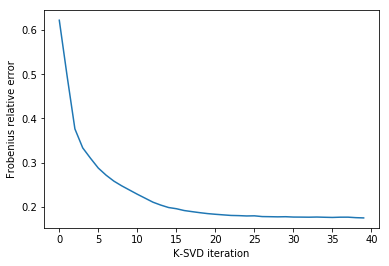

In [17]:
plt.plot(error)
plt.xlabel('K-SVD iteration')
plt.ylabel('Frobenius relative error')
plt.show()

### Example of groundtruth versus its sparse approximation
__Left__: Sparse approximation in the learned dictionary for sample_id image.

__Right__: Groundtruth for sample_id image.

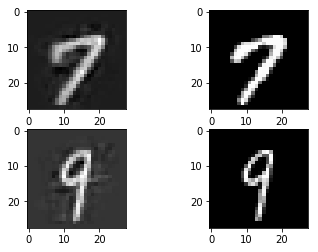

In [18]:
sample_id = 15
plt.subplot(2, 2, 1)
plt.imshow((D@X)[:,sample_id].reshape(28,28), cmap='gray')
plt.subplot(2, 2, 2)
plt.imshow(Y[:,sample_id].reshape(28,28), cmap='gray')

sample_id = 900
plt.subplot(2, 2, 3)
plt.imshow((D@X)[:,sample_id].reshape(28,28), cmap='gray')
plt.subplot(2, 2, 4)
plt.imshow(Y[:,sample_id].reshape(28,28), cmap='gray')
plt.show()

### Plot how many times is each dictionary element used (sorted)

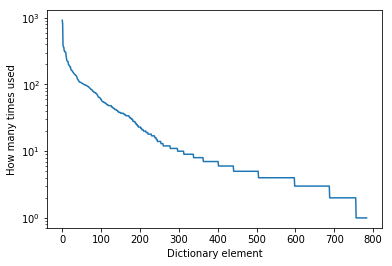

In [19]:
tmp = np.count_nonzero(X, axis = 1)
order_used = np.argsort(-tmp)
plt.plot(tmp[order_used])
plt.yscale('log')
plt.xlabel('Dictionary element')
plt.ylabel('How many times used')
plt.show()

### Draw 64 most commonly used dictionary elements

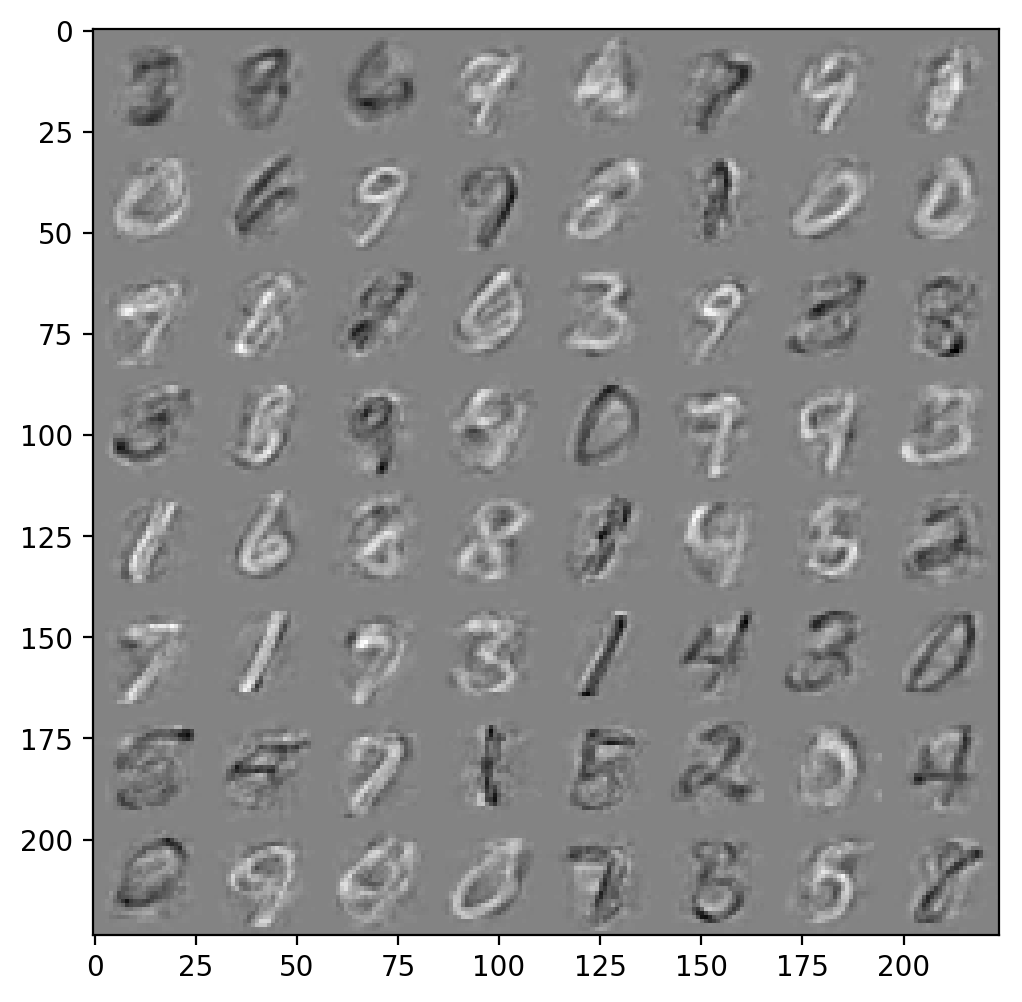

In [20]:
D_tmp = D[:,order_used[:64]]
D_tmp = D_tmp.reshape(28,28,8,8)
D_tmp = np.moveaxis(D_tmp, 2, 0)
D_tmp = np.moveaxis(D_tmp, 3, 2)
D_tmp = D_tmp.reshape(28*8, 28*8)
plt.figure(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')
plt.imshow(D_tmp, cmap = 'gray')
plt.show()

#### Final remarks:
It would be interesting to rerun the experiment on a different dataset from MNIST and see what sort of dictionary elements we recover. It might be that for MNIST the variation between digits is low and therefore our dictionary consists of pictures representing limited number of ways of writing each digit.